<a href="https://colab.research.google.com/github/jnunez03/GoogleColabRepo/blob/main/Eng%26Ret.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Engagement & Cohort

In [ ]:
import pandas as pd
import pandas_profiling
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sb
from pandas import Series, DataFrame
from pylab import *
import statsmodels.api as sm
import matplotlib.style as style
from matplotlib.ticker import MaxNLocator
from matplotlib.font_manager import FontProperties
from scipy import stats
from scipy.stats import norm
from fbprophet import Prophet
import logging

logger = logging.getLogger('pandas_gbq')
logger.propagate = False 
logging.getLogger().disabled = True

q = """
SELECT
date_Trunc(day,month) as month,
--eng
avg(L7ratio) as avgL7,
avg(L28ratio) as avgL28,
avg(L4ratio) as avgL4ratio,
avg(L2ratio) as avgL2ratio,
--cohort
avg(Under3ratio) as U3,
avg(M3ratio) as M3,
avg(M6ratio) as M6,
avg(M9ratio) as M9,
avg(M12ratio) as M12,
avg(M15ratio) as M15,
avg(M24ratio) as M24
FROM (
SELECT 
day,
(visited_in_past_7_flag / TotalUsersDaily) *100 as L7ratio,
(visited_in_past_28_flag / TotalUsersDaily) *100 as L28ratio,
(visited_4_plus_flag / TotalUsersDaily) *100 as L4ratio,
(visited_2_plus_flag / TotalUsersDaily) *100 as L2ratio,
(Under3 / TotalUsersDaily) * 100 as Under3ratio,
(ThreeM / TotalUsersDaily) * 100 as M3ratio,
(SixM / TotalUsersDaily) * 100 as M6ratio,
(NineM / TotalUsersDaily) * 100 as M9ratio,
(TwelveM / TotalUsersDaily) * 100 as M12ratio,
(FifteenM / TotalUsersDaily) * 100 as M15ratio,
(TwentyFourM / TotalUsersDaily) * 100 as M24ratio
FROM (
SELECT
day,
count(distinct tenure_regi) as TotalUsersDaily, -- Total
--engagement
count(distinct case when visited_in_past_7_flag = 1 THEN regi_id ELSE NULL END) As visited_in_past_7_flag,
count(distinct case when visited_in_past_28_flag = 1 THEN regi_id ELSE NULL END) As visited_in_past_28_flag,
count(distinct case when visited_4_plus_flag = 1 THEN regi_id ELSE NULL END) As visited_4_plus_flag,
count(distinct case when visited_2_plus_flag = 1 THEN regi_id ELSE NULL END) As visited_2_plus_flag,
--Cohort
count(distinct case when Under3 = 1 THEN tenure_regi ELSE NULL END) As Under3,
count(distinct case when ThreeM = 1 THEN tenure_regi ELSE NULL END) As ThreeM,
count(distinct case when SixM = 1 THEN tenure_regi ELSE NULL END) As SixM,
count(distinct case when NineM = 1 THEN tenure_regi ELSE NULL END) As NineM,
count(distinct case when TwelveM = 1 THEN tenure_regi ELSE NULL END) As TwelveM,
count(distinct case when FifteenM = 1 THEN tenure_regi ELSE NULL END) As FifteenM,
count(distinct case when TwentyFourM = 1 THEN tenure_regi ELSE NULL END) As TwentyFourM
FROM (            -- This is base table for monthly cohorting.
SELECT 
a.day as day,
a.tenure_regi,
b.regi_id,
a.Under3,
a.ThreeM,
a.SixM, 
a.NineM, 
a.TwelveM, 
a.FifteenM, 
a.TwentyFourM,
b.num_days_visited_past_28,	b.visited_in_past_7_flag,	b.visited_in_past_28_flag,	b.visited_4_plus_flag, b.visited_2_plus_flag
FROM `nyt-bigquery-beta-workspace.nunez_justin.DSSOR_COHORT_MONTHLY_using_start_date` a
LEFT JOIN `nyt-bigquery-beta-workspace.nunez_justin.COOKING_USAGE_BASE` b on cast(a.tenure_regi as string) = b.regi_id and a.day = b.day_dim_date
where a.day >= '2017-07-01'
)
group by 1
order by 1 asc
)
group by 1,2,3,4,5,6,7,8,9,10,11,12
order by 1 asc
)
GROUP BY 1
order by 1 asc
"""
# importing the data
df = pd.read_gbq(q,
    project_id = 'nyt-bigquery-beta-workspace',
    dialect='standard')

# Descriptive statistics, data type, data preview 
print(df.describe(), ' \n \n', '*Data Types Below* \n \n', df.dtypes ,' \n \n', df.head(n=14))

           avgL7     avgL28  avgL4ratio  ...         M12        M15        M24
count  42.000000  42.000000   42.000000  ...   42.000000  42.000000  42.000000
mean   27.964432  42.910992   22.155952  ...   39.445940  33.248051  15.926807
std    23.050467  34.345719   18.266830  ...   33.671041  31.682240  23.264094
min     0.000000   0.000000    0.000000  ...    0.000000   0.000000   0.000000
25%     0.000000   0.000000    0.000000  ...    0.023640   0.000000   0.000000
50%    40.942598  64.203468   30.835399  ...   36.096869  30.906386   0.000000
75%    45.472328  69.036644   36.403618  ...   77.666610  64.488174  32.162120
max    59.337413  82.754870   50.329029  ...  100.000000  93.925074  81.235796

[8 rows x 11 columns]  
 
 *Data Types Below* 
 
 month         datetime64[ns]
avgL7                float64
avgL28               float64
avgL4ratio           float64
avgL2ratio           float64
U3                   float64
M3                   float64
M6                   float64
M9    

In [ ]:
df1 = df[df['month'] > '2017-10-01']
df1 = df1[df1['month'] < '2020-01-01']
df1.tail()

,month,avgL7,avgL28,avgL4ratio,avgL2ratio,U3,M3,M6,M9,M12,M15,M24
25,2019-08-01,39.507620,63.001947,30.400435,47.835210,15.993458,84.006972,69.028733,50.728047,34.571544,30.985900,9.781624
26,2019-09-01,41.222507,63.622742,30.729915,48.219683,14.862517,85.137483,70.156128,54.331723,38.262163,30.826871,12.634542
27,2019-10-01,41.948993,66.108238,32.333510,50.569873,16.014909,83.985208,68.966286,55.700660,38.597695,30.470567,14.924397
28,2019-11-01,43.354170,67.203104,31.954285,50.995226,19.177204,80.823629,67.052216,55.603834,41.255059,32.872434,16.392298
29,2019-12-01,17.940492,60.027912,22.573714,42.036988,20.428228,79.571772,65.881091,54.778356,42.690104,32.610597,17.555035


In [ ]:
#df2 = df1.drop(['avgL28'], axis=1)
#df2.head()

,month,avgL7,avgL4ratio,M3,M6,M9,M12,M15,M24
1,2017-11-01,83.744621,38.297926,94.830430,88.785549,84.833241,79.737196,77.456732,68.772615
2,2017-12-01,67.329956,54.595382,92.919525,87.379652,83.168671,77.681317,75.231491,64.291315
3,2018-01-01,70.222147,57.978263,92.565937,87.563298,82.797669,76.378288,73.815794,29.429430
4,2018-02-01,67.865385,57.803597,93.059150,88.662153,83.859684,77.431313,74.951134,18.168915
5,2018-03-01,67.166036,55.365447,94.207641,89.891977,85.046730,78.870193,76.733837,17.825509


In [ ]:
#pandas_profiling.ProfileReport(df1)

# M3


In [ ]:
df1.head()

,month,avgL7,avgL28,avgL4ratio,M3,M6,M9,M12,M15,M24
4,2017-11-01,52.410588,64.157187,26.906983,93.932758,87.546114,83.567182,77.876931,75.459513,66.271639
5,2017-12-01,49.497957,73.580124,40.175367,92.482867,86.832718,82.478478,76.408540,73.817991,62.686782
6,2018-01-01,51.411115,73.208062,42.442877,92.086957,86.968854,81.947740,74.829639,72.255948,31.981355
7,2018-02-01,47.782722,70.390725,40.695651,92.427527,87.807676,82.396089,75.144390,72.747279,22.089402
8,2018-03-01,45.427691,67.626221,37.445167,93.515231,88.782119,83.122750,76.113661,73.982226,21.725072


In [ ]:
df1 = df1[df1['month'] < '2020-01-01']

df1 = df1[df1['month'] < '2019-12-01']

df1.head()

,month,avgL7,avgL28,avgL4ratio,avgL2ratio,M3,M6,M9,M12,M15,M24
4,2017-11-01,59.337413,71.857345,31.520120,53.814575,92.496985,84.027962,78.837953,74.280534,71.648337,62.218292
5,2017-12-01,57.231471,82.753369,47.297321,68.069434,90.383517,82.800841,77.566419,72.947795,70.318838,58.586426
6,2018-01-01,58.681770,82.754870,50.329029,69.294021,89.355479,82.243677,76.747928,72.148273,69.454437,14.153940
7,2018-02-01,54.169824,78.555630,47.891443,65.985693,89.124983,82.405951,76.687757,72.053693,69.529741,0.651589
8,2018-03-01,51.510333,75.520112,43.815299,61.907856,90.305417,83.621227,77.907977,73.165841,70.825972,0.561423


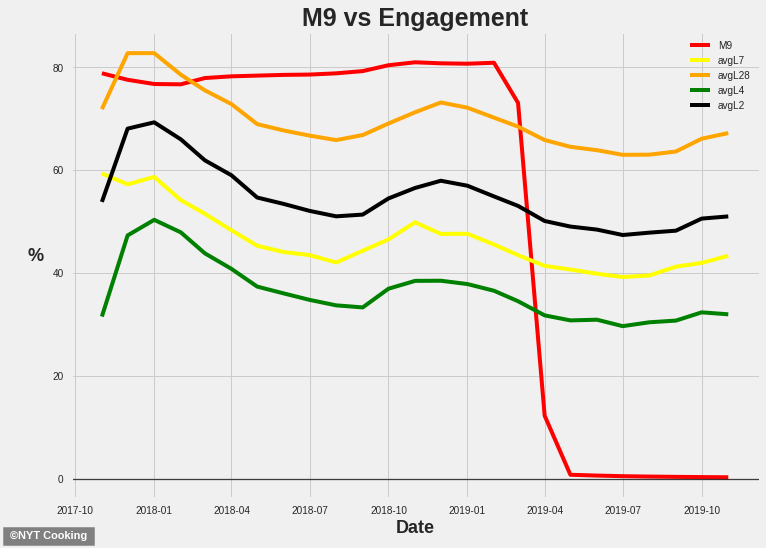

In [ ]:
%matplotlib inline
plt.style.use('fivethirtyeight')
#plt.style.use('bmh')   #bmh, ggplot,seaborn-notebook,seaborn-deep,dark_background
rcParams['figure.figsize'] = 11,8

colors = [[0,0,0], [230/255,159/255,0], [86/255,180/255,233/255], [0,158/255,115/255],
          [213/255,94/255,0], [0,114/255,178/255]]

# sb.set_context("notebook",font_scale=1.001,rc={"lines.linewidth":2.5})
# sb.lineplot(x='month', y='M3', data=df1)
# sb.lineplot(x='month', y='avgL7', data=df1)
# sb.lineplot(x='month', y='avgL28', data=df1)
# sb.lineplot(x='month', y='avgL4ratio', data=df1)

plt.plot(df1['month'], df1['M9'], label='M9', color='red')
plt.plot(df1['month'], df1['avgL7'], label='avgL7', color='yellow')
plt.plot(df1['month'], df1['avgL28'], label='avgL28', color='orange')
plt.plot(df1['month'], df1['avgL4ratio'], label='avgL4', color='green')
plt.plot(df1['month'], df1['avgL2ratio'], label='avgL2', color='black')



plt.title('M9 vs Engagement',fontsize=25,weight='bold')
plt.ylabel('%     ', fontsize=18, rotation=0, weight='bold')
plt.xlabel('Date',fontsize=18, weight='bold')
plt.axhline(y = 0, color = 'black', linewidth = 1.3, alpha = .7)
plt.legend(loc='upper right')
#plt.text(x=1, y=1000, s='NYT Cooking', fontsize=9, color='#f0f0f0',backgroundcolor='grey')
plt.figtext(0, 0,' ©NYT Cooking ', fontsize=11, color='white',backgroundcolor='grey',weight= 'bold') #rotation=0, #color='black')
plt.show() 

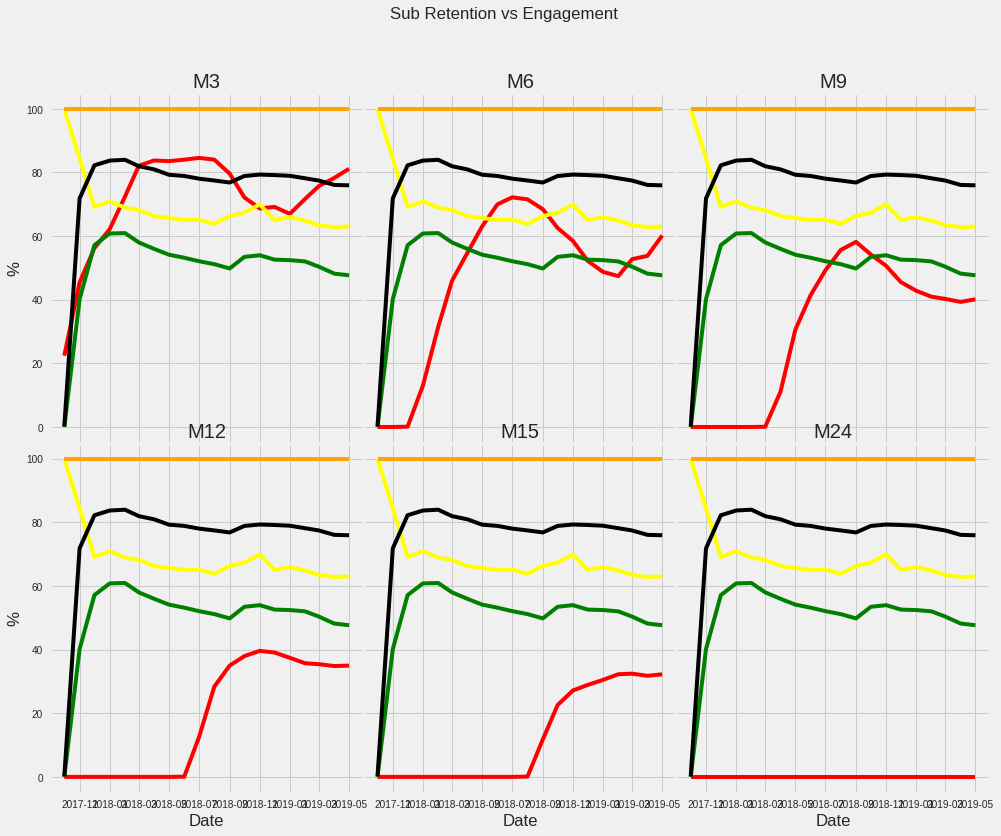

In [ ]:
%matplotlib inline
plt.style.use('fivethirtyeight')
#plt.style.use('bmh')   #bmh, ggplot,seaborn-notebook,seaborn-deep,dark_background
rcParams['figure.figsize'] = 15,12
#sharex='col', sharey='row',
fig, axs = plt.subplots(2, 3, gridspec_kw={'hspace': 0, 'wspace': 0})
(ax1, ax2, ax3),(ax4, ax5, ax6) = axs

fig.suptitle('Sub Retention vs Engagement')

#ax1.plot(x, y)
ax1.plot(df1['month'], df1['M3'], label='M3', color='red')
ax1.plot(df1['month'], df1['avgL7'], label='avgL7', color='yellow')
ax1.plot(df1['month'], df1['avgL28'], label='avgL28', color='orange')
ax1.plot(df1['month'], df1['avgL4ratio'], label='avgL4', color='green')
ax1.plot(df1['month'], df1['avgL2ratio'], label='avgL2', color='black')
ax1.set_title('M3')

#ax2.plot(x, y)
ax2.plot(df1['month'], df1['M6'], label='M6', color='red')
ax2.plot(df1['month'], df1['avgL7'], label='avgL7', color='yellow')
ax2.plot(df1['month'], df1['avgL28'], label='avgL28', color='orange')
ax2.plot(df1['month'], df1['avgL4ratio'], label='avgL4', color='green')
ax2.plot(df1['month'], df1['avgL2ratio'], label='avgL2', color='black')
ax2.set_title('M6')

#ax3.plot(x, y)
ax3.plot(df1['month'], df1['M9'], label='M9', color='red')
ax3.plot(df1['month'], df1['avgL7'], label='avgL7', color='yellow')
ax3.plot(df1['month'], df1['avgL28'], label='avgL28', color='orange')
ax3.plot(df1['month'], df1['avgL4ratio'], label='avgL4', color='green')
ax3.plot(df1['month'], df1['avgL2ratio'], label='avgL2', color='black')
ax3.set_title('M9')

#ax4.plot(x, y)
ax4.plot(df1['month'], df1['M12'], label='M12', color='red')
ax4.plot(df1['month'], df1['avgL7'], label='avgL7', color='yellow')
ax4.plot(df1['month'], df1['avgL28'], label='avgL28', color='orange')
ax4.plot(df1['month'], df1['avgL4ratio'], label='avgL4', color='green')
ax4.plot(df1['month'], df1['avgL2ratio'], label='avgL2', color='black')
ax4.set_title('M12')

#ax5.plot(x, y)
ax5.plot(df1['month'], df1['M15'], label='M15', color='red')
ax5.plot(df1['month'], df1['avgL7'], label='avgL7', color='yellow')
ax5.plot(df1['month'], df1['avgL28'], label='avgL28', color='orange')
ax5.plot(df1['month'], df1['avgL4ratio'], label='avgL4', color='green')
ax5.plot(df1['month'], df1['avgL2ratio'], label='avgL2', color='black')
ax5.set_title('M15')

#ax6.plot(x, y)
ax6.plot(df1['month'], df1['M24'], label='M24', color='red')
ax6.plot(df1['month'], df1['avgL7'], label='avgL7', color='yellow')
ax6.plot(df1['month'], df1['avgL28'], label='avgL28', color='orange')
ax6.plot(df1['month'], df1['avgL4ratio'], label='avgL4', color='green')
ax6.plot(df1['month'], df1['avgL2ratio'], label='avgL2', color='black')
ax6.set_title('M24')

for ax in axs.flat:
    ax.set(xlabel='Date', ylabel='%')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()


In [ ]:
#sb.heatmap(df1, annot=True, fmt="d", linewidths=.5)
print(
stats.pearsonr(df1['M6'], df1['avgL7']), '+',
stats.pearsonr(df1['M6'], df1['avgL4ratio']), '+',
stats.pearsonr(df1['M6'], df1['avgL28']), '+',
stats.pearsonr(df1['M6'], df1['avgL2ratio'])
)


(0.4376415096130883, 0.028678227370883397) + (0.4540581196307998, 0.022607723430290265) + (0.45513745321139143, 0.022248329399772594) + (0.4595890736982702, 0.020814656942827907)


# Using Start Date and End of Month

# U3

In [ ]:
U3 = df1.drop(['M3','M6','M9','M12','M15','M24'], axis=1)
#U3 = U3[U3['month'] > '2017-11-01']
U3.head(n=34)

,month,avgL7,avgL28,avgL4ratio,avgL2ratio,U3
4,2017-11-01,59.337413,71.857345,31.520120,53.814575,56.033320
5,2017-12-01,57.231471,82.753369,47.297321,68.069434,43.695624
6,2018-01-01,58.681770,82.754870,50.329029,69.294021,37.261006
7,2018-02-01,54.169824,78.555630,47.891443,65.985693,27.895771
8,2018-03-01,51.510333,75.520112,43.815299,61.907856,17.135755
9,2018-04-01,48.299316,72.848457,40.791061,58.994881,14.695878
10,2018-05-01,45.287634,68.948526,37.343664,54.667180,14.707204
11,2018-06-01,44.061863,67.700201,36.014311,53.419180,14.024155
12,2018-07-01,43.474663,66.716658,34.762038,52.073850,13.385529
13,2018-08-01,42.033424,65.836368,33.695634,51.010974,13.824697


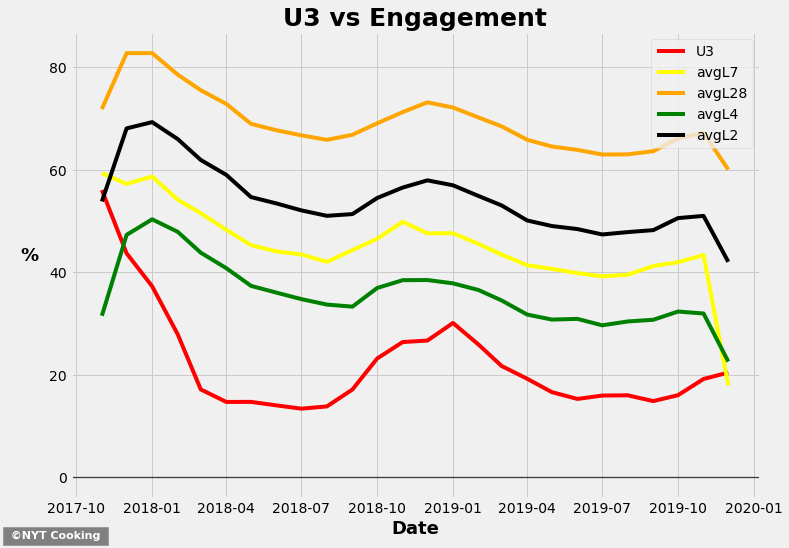

In [ ]:
%matplotlib inline
plt.style.use('fivethirtyeight')
#plt.style.use('bmh')   #bmh, ggplot,seaborn-notebook,seaborn-deep,dark_background
rcParams['figure.figsize'] = 11,8

colors = [[0,0,0], [230/255,159/255,0], [86/255,180/255,233/255], [0,158/255,115/255],
          [213/255,94/255,0], [0,114/255,178/255]]

# sb.set_context("notebook",font_scale=1.001,rc={"lines.linewidth":2.5})
# sb.lineplot(x='month', y='M3', data=df1)
# sb.lineplot(x='month', y='avgL7', data=df1)
# sb.lineplot(x='month', y='avgL28', data=df1)
# sb.lineplot(x='month', y='avgL4ratio', data=df1)

plt.plot(U3['month'], U3['U3'], label='U3', color='red')
plt.plot(U3['month'], U3['avgL7'], label='avgL7', color='yellow')
plt.plot(U3['month'], U3['avgL28'], label='avgL28', color='orange')
plt.plot(U3['month'], U3['avgL4ratio'], label='avgL4', color='green')
plt.plot(U3['month'], U3['avgL2ratio'], label='avgL2', color='black')



plt.title('U3 vs Engagement',fontsize=25,weight='bold')
plt.ylabel('%     ', fontsize=18, rotation=0, weight='bold')
plt.xlabel('Date',fontsize=18, weight='bold')
plt.axhline(y = 0, color = 'black', linewidth = 1.3, alpha = .7)
plt.legend(loc='upper right')
#plt.text(x=1, y=1000, s='NYT Cooking', fontsize=9, color='#f0f0f0',backgroundcolor='grey')
plt.figtext(0, 0,' ©NYT Cooking ', fontsize=11, color='white',backgroundcolor='grey',weight= 'bold') #rotation=0, #color='black')
plt.show()

In [ ]:
print(' U3 vs..', '\n',
'L7:',stats.pearsonr(U3['U3'], U3['avgL7']),'\n',
'L4:', stats.pearsonr(U3['U3'], U3['avgL4ratio']), '\n',
'L28:',stats.pearsonr(U3['U3'], U3['avgL28']), '\n',
'L2:',stats.pearsonr(U3['U3'], U3['avgL2ratio']),
)

 U3 vs.. 
 L7: (0.6276447656899041, 0.0005983092282367874) 
 L4: (0.38462765202335125, 0.05236137921370286) 
 L28: (0.6344360605032502, 0.0004997431311207577) 
 L2: (0.525691215848685, 0.00581381875972846)


# M3

In [ ]:
df3 = df1.drop(['M6','M9','M12','M15','M24'], axis=1)
df3 = df3[df3['month'] > '2017-11-01']
df3.head(n=34)

,month,avgL7,avgL28,avgL4ratio,avgL2ratio,M3
5,2017-12-01,57.231471,82.753369,47.297321,68.069434,56.306194
6,2018-01-01,58.681770,82.754870,50.329029,69.294021,62.738994
7,2018-02-01,54.169824,78.555630,47.891443,65.985693,72.104229
8,2018-03-01,51.510333,75.520112,43.815299,61.907856,82.864245
9,2018-04-01,48.299316,72.848457,40.791061,58.994881,85.304122
10,2018-05-01,45.287634,68.948526,37.343664,54.667180,85.292796
11,2018-06-01,44.061863,67.700201,36.014311,53.419180,85.975845
12,2018-07-01,43.474663,66.716658,34.762038,52.073850,86.614471
13,2018-08-01,42.033424,65.836368,33.695634,51.010974,86.175303
14,2018-09-01,44.316884,66.821275,33.293068,51.349280,82.875160


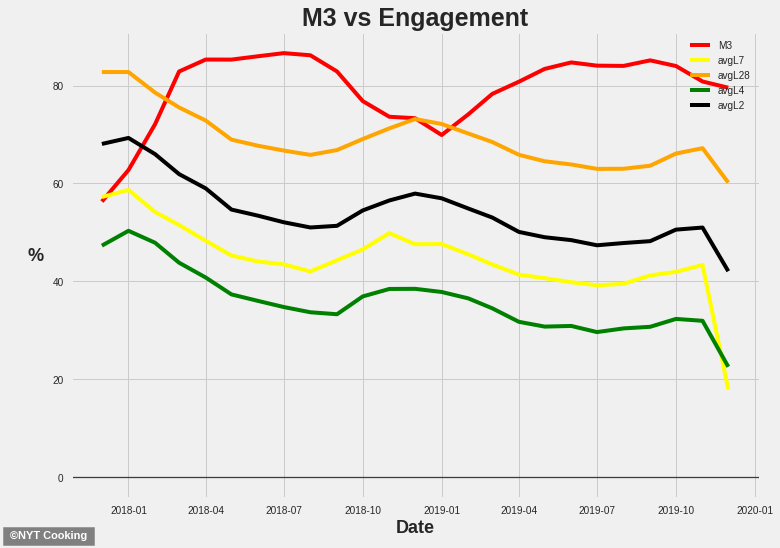

In [ ]:
%matplotlib inline
plt.style.use('fivethirtyeight')
#plt.style.use('bmh')   #bmh, ggplot,seaborn-notebook,seaborn-deep,dark_background
rcParams['figure.figsize'] = 11,8

colors = [[0,0,0], [230/255,159/255,0], [86/255,180/255,233/255], [0,158/255,115/255],
          [213/255,94/255,0], [0,114/255,178/255]]

# sb.set_context("notebook",font_scale=1.001,rc={"lines.linewidth":2.5})
# sb.lineplot(x='month', y='M3', data=df1)
# sb.lineplot(x='month', y='avgL7', data=df1)
# sb.lineplot(x='month', y='avgL28', data=df1)
# sb.lineplot(x='month', y='avgL4ratio', data=df1)

plt.plot(df3['month'], df3['M3'], label='M3', color='red')
plt.plot(df3['month'], df3['avgL7'], label='avgL7', color='yellow')
plt.plot(df3['month'], df3['avgL28'], label='avgL28', color='orange')
plt.plot(df3['month'], df3['avgL4ratio'], label='avgL4', color='green')
plt.plot(df3['month'], df3['avgL2ratio'], label='avgL2', color='black')



plt.title('M3 vs Engagement',fontsize=25,weight='bold')
plt.ylabel('%     ', fontsize=18, rotation=0, weight='bold')
plt.xlabel('Date',fontsize=18, weight='bold')
plt.axhline(y = 0, color = 'black', linewidth = 1.3, alpha = .7)
plt.legend(loc='upper right')
#plt.text(x=1, y=1000, s='NYT Cooking', fontsize=9, color='#f0f0f0',backgroundcolor='grey')
plt.figtext(0, 0,' ©NYT Cooking ', fontsize=11, color='white',backgroundcolor='grey',weight= 'bold') #rotation=0, #color='black')
plt.show() 

In [ ]:
print(' M3 vs..', '\n',
'L7:',stats.pearsonr(df3['M3'], df3['avgL7']),'\n',
'L4:', stats.pearsonr(df3['M3'], df3['avgL4ratio']), '\n',
'L28:',stats.pearsonr(df3['M3'], df3['avgL28']), '\n',
'L2:',stats.pearsonr(df3['M3'], df3['avgL2ratio']),
)

 M3 vs.. 
 L7: (-0.5581158740640403, 0.0037407941257631343) 
 L4: (-0.6514598283238215, 0.00041946827847776834) 
 L28: (-0.7798075423540632, 4.318047896387414e-06) 
 L2: (-0.7214843892570159, 4.698455868151105e-05)


In [ ]:
pandas_profiling.ProfileReport(df3)

/usr/local/lib/python3.6/dist-packages/pandas_profiling/describe.py:392: FutureWarning:

The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.



Number of variables,7
Number of observations,25
Total Missing (%),0.0%
Total size in memory,1.5 KiB
Average record size in memory,61.1 B
Numeric,4
Categorical,0
Boolean,0
Date,1
Text (Unique),0
Rejected,2


# M6

In [ ]:
df6 = df1.drop(['U3','M3','M9','M12','M15','M24'], axis=1)
df6 = df6[df6['month'] > '2017-12-01']
df6.head(n=34)

,month,avgL7,avgL28,avgL4ratio,avgL2ratio,M6
6,2018-01-01,58.681770,82.754870,50.329029,69.294021,11.984338
7,2018-02-01,54.169824,78.555630,47.891443,65.985693,29.228743
8,2018-03-01,51.510333,75.520112,43.815299,61.907856,43.207289
9,2018-04-01,48.299316,72.848457,40.791061,58.994881,52.291695
10,2018-05-01,45.287634,68.948526,37.343664,54.667180,61.362843
11,2018-06-01,44.061863,67.700201,36.014311,53.419180,69.618619
12,2018-07-01,43.474663,66.716658,34.762038,52.073850,72.509179
13,2018-08-01,42.033424,65.836368,33.695634,51.010974,72.303666
14,2018-09-01,44.316884,66.821275,33.293068,51.349280,70.234410
15,2018-10-01,46.523615,69.066016,36.930441,54.489534,65.486811


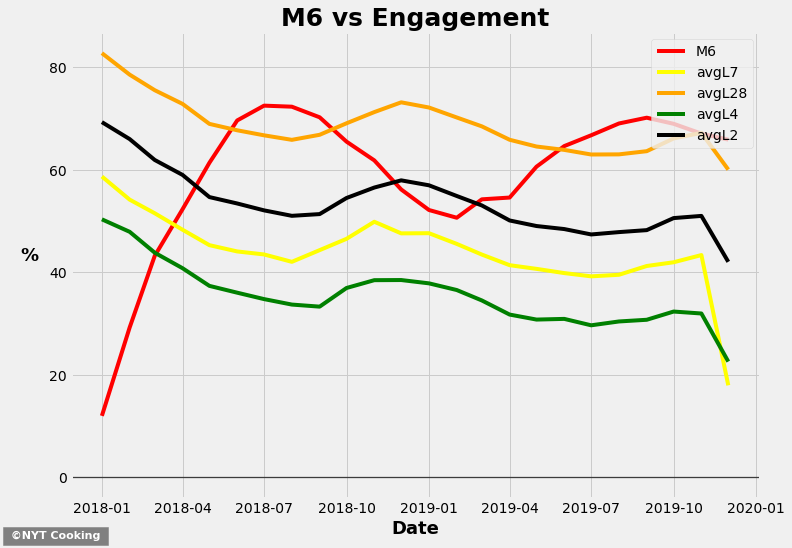

In [ ]:
%matplotlib inline
plt.style.use('fivethirtyeight')
#plt.style.use('bmh')   #bmh, ggplot,seaborn-notebook,seaborn-deep,dark_background
rcParams['figure.figsize'] = 11,8

colors = [[0,0,0], [230/255,159/255,0], [86/255,180/255,233/255], [0,158/255,115/255],
          [213/255,94/255,0], [0,114/255,178/255]]

# sb.set_context("notebook",font_scale=1.001,rc={"lines.linewidth":2.5})
# sb.lineplot(x='month', y='M3', data=df1)
# sb.lineplot(x='month', y='avgL7', data=df1)
# sb.lineplot(x='month', y='avgL28', data=df1)
# sb.lineplot(x='month', y='avgL4ratio', data=df1)

plt.plot(df6['month'], df6['M6'], label='M6', color='red')
plt.plot(df6['month'], df6['avgL7'], label='avgL7', color='yellow')
plt.plot(df6['month'], df6['avgL28'], label='avgL28', color='orange')
plt.plot(df6['month'], df6['avgL4ratio'], label='avgL4', color='green')
plt.plot(df6['month'], df6['avgL2ratio'], label='avgL2', color='black')



plt.title('M6 vs Engagement',fontsize=25,weight='bold')
plt.ylabel('%     ', fontsize=18, rotation=0, weight='bold')
plt.xlabel('Date',fontsize=18, weight='bold')
plt.axhline(y = 0, color = 'black', linewidth = 1.3, alpha = .7)
plt.legend(loc='upper right')
#plt.text(x=1, y=1000, s='NYT Cooking', fontsize=9, color='#f0f0f0',backgroundcolor='grey')
plt.figtext(0, 0,' ©NYT Cooking ', fontsize=11, color='white',backgroundcolor='grey',weight= 'bold') #rotation=0, #color='black')
plt.show() 

In [ ]:
print(' M6 vs..', '\n',
'L7:',stats.pearsonr(df6['M6'], df6['avgL7']),'\n',
'L4:', stats.pearsonr(df6['M6'], df6['avgL4ratio']), '\n',
'L28:',stats.pearsonr(df6['M6'], df6['avgL28']), '\n',
'L2:',stats.pearsonr(df6['M6'], df6['avgL2ratio']),
)

 M6 vs.. 
 L7: (-0.6245177099633332, 0.0011059779209780449) 
 L4: (-0.8055322855202537, 2.0434321859600966e-06) 
 L28: (-0.8618917274096013, 6.254427867995298e-08) 
 L2: (-0.8396577519472793, 2.897588386088949e-07)


In [ ]:
pandas_profiling.ProfileReport(df6)

/usr/local/lib/python3.6/dist-packages/pandas_profiling/describe.py:392: FutureWarning:

The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.



Number of variables,7
Number of observations,24
Total Missing (%),0.0%
Total size in memory,1.4 KiB
Average record size in memory,61.3 B
Numeric,4
Categorical,0
Boolean,0
Date,1
Text (Unique),0
Rejected,2


# M9

In [ ]:
df9 = df1.drop(['M3','M6','M12','M15','M24'], axis=1)
df9 = df9[df9['month'] > '2018-05-01']
df9.head(n=34)

,month,avgL7,avgL28,avgL4ratio,avgL2ratio,M9
11,2018-06-01,44.061863,67.700201,36.014311,53.419180,37.248666
12,2018-07-01,43.474663,66.716658,34.762038,52.073850,45.708014
13,2018-08-01,42.033424,65.836368,33.695634,51.010974,53.226895
14,2018-09-01,44.316884,66.821275,33.293068,51.349280,57.912161
15,2018-10-01,46.523615,69.066016,36.930441,54.489534,55.507661
16,2018-11-01,49.852996,71.249614,38.455794,56.527651,52.403219
17,2018-12-01,47.588874,73.154815,38.482863,57.932512,48.132337
18,2019-01-01,47.620604,72.143128,37.836451,56.965625,44.938797
19,2019-02-01,45.533892,70.199981,36.533387,54.882268,42.994046
20,2019-03-01,43.452285,68.465842,34.499354,53.037080,41.832994


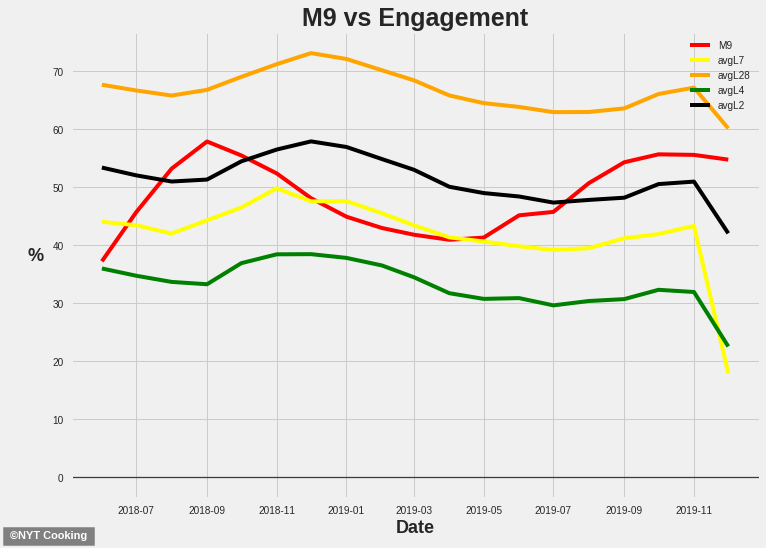

In [ ]:
%matplotlib inline
plt.style.use('fivethirtyeight')
#plt.style.use('bmh')   #bmh, ggplot,seaborn-notebook,seaborn-deep,dark_background
rcParams['figure.figsize'] = 11,8

colors = [[0,0,0], [230/255,159/255,0], [86/255,180/255,233/255], [0,158/255,115/255],
          [213/255,94/255,0], [0,114/255,178/255]]

# sb.set_context("notebook",font_scale=1.001,rc={"lines.linewidth":2.5})
# sb.lineplot(x='month', y='M3', data=df1)
# sb.lineplot(x='month', y='avgL7', data=df1)
# sb.lineplot(x='month', y='avgL28', data=df1)
# sb.lineplot(x='month', y='avgL4ratio', data=df1)

plt.plot(df9['month'], df9['M9'], label='M9', color='red')
plt.plot(df9['month'], df9['avgL7'], label='avgL7', color='yellow')
plt.plot(df9['month'], df9['avgL28'], label='avgL28', color='orange')
plt.plot(df9['month'], df9['avgL4ratio'], label='avgL4', color='green')
plt.plot(df9['month'], df9['avgL2ratio'], label='avgL2', color='black')



plt.title('M9 vs Engagement',fontsize=25,weight='bold')
plt.ylabel('%     ', fontsize=18, rotation=0, weight='bold')
plt.xlabel('Date',fontsize=18, weight='bold')
plt.axhline(y = 0, color = 'black', linewidth = 1.3, alpha = .7)
plt.legend(loc='upper right')
#plt.text(x=1, y=1000, s='NYT Cooking', fontsize=9, color='#f0f0f0',backgroundcolor='grey')
plt.figtext(0, 0,' ©NYT Cooking ', fontsize=11, color='white',backgroundcolor='grey',weight= 'bold') #rotation=0, #color='black')
plt.show() 

In [ ]:
print(' M9 vs..', '\n',
'L7:',stats.pearsonr(df9['M9'], df9['avgL7']),'\n',
'L4:', stats.pearsonr(df9['M9'], df9['avgL4ratio']), '\n',
'L28:',stats.pearsonr(df9['M9'], df9['avgL28']), '\n',
'L2:',stats.pearsonr(df9['M9'], df9['avgL2ratio']),
)

 M9 vs.. 
 L7: (-0.15907830345739948, 0.5153730818014658) 
 L4: (-0.20340362877267584, 0.4036005518795688) 
 L28: (-0.15495269159383673, 0.526463743134983) 
 L2: (-0.19150327900250497, 0.4322284103816622)


In [ ]:
pandas_profiling.ProfileReport(df9)

/usr/local/lib/python3.6/dist-packages/pandas_profiling/describe.py:392: FutureWarning:

The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.



Number of variables,7
Number of observations,19
Total Missing (%),0.0%
Total size in memory,1.2 KiB
Average record size in memory,62.7 B
Numeric,4
Categorical,0
Boolean,0
Date,1
Text (Unique),0
Rejected,2


# M12

In [ ]:
df12 = df1.drop(['M3','M6','M9','M15','M24'], axis=1)
df12 = df12[df12['month'] > '2018-07-01']
df12 = df12[df12['month'] < '2019-12-01']
df12.head(n=34)

,month,avgL7,avgL28,avgL4ratio,avgL2ratio,M12
13,2018-08-01,42.033424,65.836368,33.695634,51.010974,24.388768
14,2018-09-01,44.316884,66.821275,33.293068,51.349280,31.562305
15,2018-10-01,46.523615,69.066016,36.930441,54.489534,36.084007
16,2018-11-01,49.852996,71.249614,38.455794,56.527651,39.127540
17,2018-12-01,47.588874,73.154815,38.482863,57.932512,40.230755
18,2019-01-01,47.620604,72.143128,37.836451,56.965625,38.429769
19,2019-02-01,45.533892,70.199981,36.533387,54.882268,36.749991
20,2019-03-01,43.452285,68.465842,34.499354,53.037080,36.109732
21,2019-04-01,41.380843,65.852795,31.745693,50.105178,35.507872
22,2019-05-01,40.662688,64.531396,30.769344,49.020512,35.301639


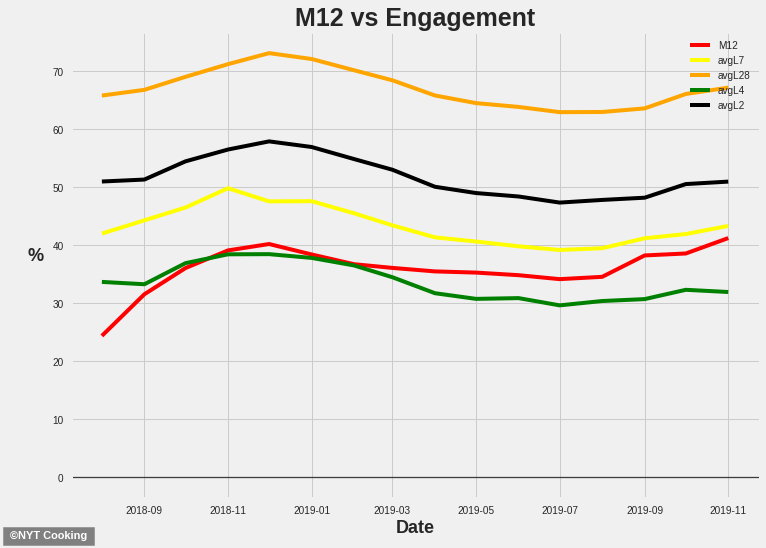

In [ ]:
%matplotlib inline
plt.style.use('fivethirtyeight')
#plt.style.use('bmh')   #bmh, ggplot,seaborn-notebook,seaborn-deep,dark_background
rcParams['figure.figsize'] = 11,8

colors = [[0,0,0], [230/255,159/255,0], [86/255,180/255,233/255], [0,158/255,115/255],
          [213/255,94/255,0], [0,114/255,178/255]]

# sb.set_context("notebook",font_scale=1.001,rc={"lines.linewidth":2.5})
# sb.lineplot(x='month', y='M3', data=df1)
# sb.lineplot(x='month', y='avgL7', data=df1)
# sb.lineplot(x='month', y='avgL28', data=df1)
# sb.lineplot(x='month', y='avgL4ratio', data=df1)

plt.plot(df12['month'], df12['M12'], label='M12', color='red')
plt.plot(df12['month'], df12['avgL7'], label='avgL7', color='yellow')
plt.plot(df12['month'], df12['avgL28'], label='avgL28', color='orange')
plt.plot(df12['month'], df12['avgL4ratio'], label='avgL4', color='green')
plt.plot(df12['month'], df12['avgL2ratio'], label='avgL2', color='black')



plt.title('M12 vs Engagement',fontsize=25,weight='bold')
plt.ylabel('%     ', fontsize=18, rotation=0, weight='bold')
plt.xlabel('Date',fontsize=18, weight='bold')
plt.axhline(y = 0, color = 'black', linewidth = 1.3, alpha = .7)
plt.legend(loc='upper right')
#plt.text(x=1, y=1000, s='NYT Cooking', fontsize=9, color='#f0f0f0',backgroundcolor='grey')
plt.figtext(0, 0,' ©NYT Cooking ', fontsize=11, color='white',backgroundcolor='grey',weight= 'bold') #rotation=0, #color='black')
plt.show() 

In [ ]:
print(' M12 vs..', '\n',
'L7:',stats.pearsonr(df12['M12'], df12['avgL7']),'\n',
'L4:', stats.pearsonr(df12['M12'], df12['avgL4ratio']), '\n',
'L28:',stats.pearsonr(df12['M12'], df12['avgL28']), '\n',
'L2:',stats.pearsonr(df12['M12'], df12['avgL2ratio']),
)

 M12 vs.. 
 L7: (0.3789861760571727, 0.14771885803699314) 
 L4: (0.2632974061674169, 0.3244820326539964) 
 L28: (0.40479067244474837, 0.11988227286313916) 
 L2: (0.35153377282283993, 0.18182283414573022)


In [ ]:
pandas_profiling.ProfileReport(df12)

/usr/local/lib/python3.6/dist-packages/pandas_profiling/describe.py:392: FutureWarning:

The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.



Number of variables,7
Number of observations,16
Total Missing (%),0.0%
Total size in memory,1.0 KiB
Average record size in memory,64.0 B
Numeric,3
Categorical,0
Boolean,0
Date,1
Text (Unique),0
Rejected,3


# M15

In [ ]:
df15 = df1.drop(['M3','M6','M9','M12','M24'], axis=1)
df15 = df15[df15['month'] > '2018-09-01']
df15 = df15[df15['month'] < '2019-12-01']
df15.head(n=34)

,month,avgL7,avgL28,avgL4ratio,avgL2ratio,M15
15,2018-10-01,46.523615,69.066016,36.930441,54.489534,20.197078
16,2018-11-01,49.852996,71.249614,38.455794,56.527651,25.490101
17,2018-12-01,47.588874,73.154815,38.482863,57.932512,28.493712
18,2019-01-01,47.620604,72.143128,37.836451,56.965625,30.352723
19,2019-02-01,45.533892,70.199981,36.533387,54.882268,32.616608
20,2019-03-01,43.452285,68.465842,34.499354,53.037080,32.633880
21,2019-04-01,41.380843,65.852795,31.745693,50.105178,31.934029
22,2019-05-01,40.662688,64.531396,30.769344,49.020512,32.084695
23,2019-06-01,39.838415,63.875540,30.901453,48.428139,31.779242
24,2019-07-01,39.203432,62.975662,29.650348,47.376484,31.189535


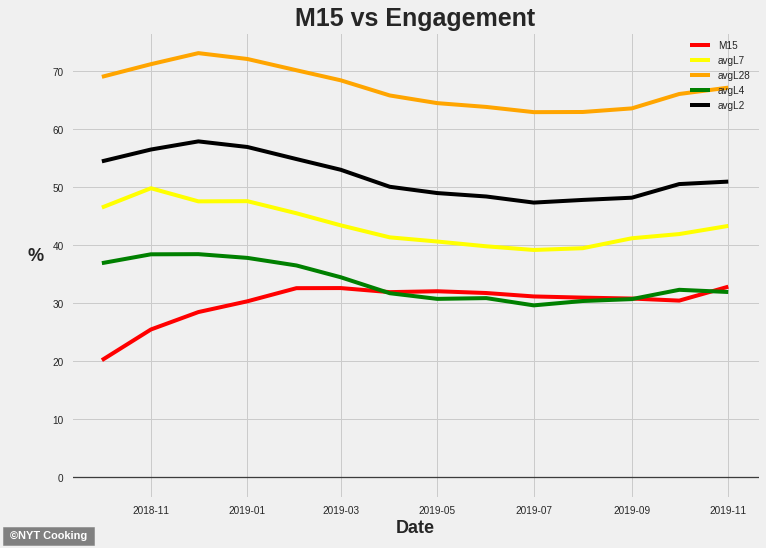

In [ ]:
%matplotlib inline
plt.style.use('fivethirtyeight')
#plt.style.use('bmh')   #bmh, ggplot,seaborn-notebook,seaborn-deep,dark_background
rcParams['figure.figsize'] = 11,8

colors = [[0,0,0], [230/255,159/255,0], [86/255,180/255,233/255], [0,158/255,115/255],
          [213/255,94/255,0], [0,114/255,178/255]]

# sb.set_context("notebook",font_scale=1.001,rc={"lines.linewidth":2.5})
# sb.lineplot(x='month', y='M3', data=df1)
# sb.lineplot(x='month', y='avgL7', data=df1)
# sb.lineplot(x='month', y='avgL28', data=df1)
# sb.lineplot(x='month', y='avgL4ratio', data=df1)

plt.plot(df15['month'], df15['M15'], label='M15', color='red')
plt.plot(df15['month'], df15['avgL7'], label='avgL7', color='yellow')
plt.plot(df15['month'], df15['avgL28'], label='avgL28', color='orange')
plt.plot(df15['month'], df15['avgL4ratio'], label='avgL4', color='green')
plt.plot(df15['month'], df15['avgL2ratio'], label='avgL2', color='black')



plt.title('M15 vs Engagement',fontsize=25,weight='bold')
plt.ylabel('%     ', fontsize=18, rotation=0, weight='bold')
plt.xlabel('Date',fontsize=18, weight='bold')
plt.axhline(y = 0, color = 'black', linewidth = 1.3, alpha = .7)
plt.legend(loc='upper right')
#plt.text(x=1, y=1000, s='NYT Cooking', fontsize=9, color='#f0f0f0',backgroundcolor='grey')
plt.figtext(0, 0,' ©NYT Cooking ', fontsize=11, color='white',backgroundcolor='grey',weight= 'bold') #rotation=0, #color='black')
plt.show() 

In [ ]:
print(' M15 vs..', '\n',
'L7:',stats.pearsonr(df15['M15'], df15['avgL7']),'\n',
'L4:', stats.pearsonr(df15['M15'], df15['avgL4ratio']), '\n',
'L28:',stats.pearsonr(df15['M15'], df15['avgL28']), '\n',
'L2:',stats.pearsonr(df15['M15'], df15['avgL2ratio']),
)

 M15 vs.. 
 L7: (-0.5557305703104869, 0.03907728822199478) 
 L4: (-0.53931538833649, 0.046560291871513754) 
 L28: (-0.3772467059567308, 0.1836171507587598) 
 L2: (-0.4467183772616512, 0.10930418771238368)


In [ ]:
pandas_profiling.ProfileReport(df15)

/usr/local/lib/python3.6/dist-packages/pandas_profiling/describe.py:392: FutureWarning:

The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.



Number of variables,7
Number of observations,14
Total Missing (%),0.0%
Total size in memory,912.0 B
Average record size in memory,65.1 B
Numeric,3
Categorical,0
Boolean,0
Date,1
Text (Unique),0
Rejected,3


# M24

In [ ]:
df24 = df1.drop(['M3','M6','M9','M12','M15'], axis=1)
df24.head(n=34)

,month,avgL7,avgL28,avgL4ratio,avgL2ratio,M24
0,2017-07-01,0.000000,0.000000,0.000000,0.000000,0.000000
1,2017-08-01,0.000000,0.000000,0.000000,0.000000,0.000000
2,2017-09-01,0.000000,0.000000,0.000000,0.000000,0.000000
3,2017-10-01,0.470132,0.470132,0.000000,0.001591,0.000000
4,2017-11-01,59.337413,71.857345,31.520120,53.814575,0.000000
5,2017-12-01,57.231471,82.753369,47.297321,68.069434,0.000000
6,2018-01-01,58.681770,82.754870,50.329029,69.294021,0.000000
7,2018-02-01,54.169824,78.555630,47.891443,65.985693,0.000000
8,2018-03-01,51.510333,75.520112,43.815299,61.907856,0.000000
9,2018-04-01,48.299316,72.848457,40.791061,58.994881,0.000000


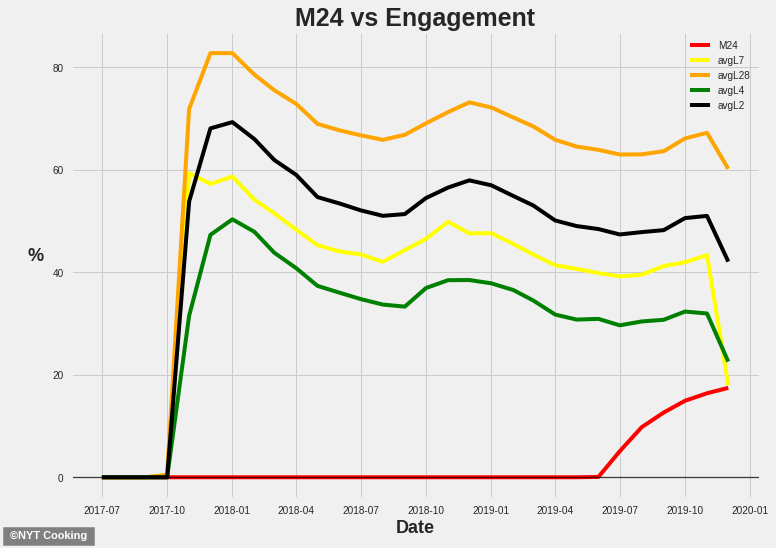

In [ ]:
%matplotlib inline
plt.style.use('fivethirtyeight')
#plt.style.use('bmh')   #bmh, ggplot,seaborn-notebook,seaborn-deep,dark_background
rcParams['figure.figsize'] = 11,8

colors = [[0,0,0], [230/255,159/255,0], [86/255,180/255,233/255], [0,158/255,115/255],
          [213/255,94/255,0], [0,114/255,178/255]]

# sb.set_context("notebook",font_scale=1.001,rc={"lines.linewidth":2.5})
# sb.lineplot(x='month', y='M3', data=df1)
# sb.lineplot(x='month', y='avgL7', data=df1)
# sb.lineplot(x='month', y='avgL28', data=df1)
# sb.lineplot(x='month', y='avgL4ratio', data=df1)

plt.plot(df24['month'], df24['M24'], label='M24', color='red')
plt.plot(df24['month'], df24['avgL7'], label='avgL7', color='yellow')
plt.plot(df24['month'], df24['avgL28'], label='avgL28', color='orange')
plt.plot(df24['month'], df24['avgL4ratio'], label='avgL4', color='green')
plt.plot(df24['month'], df24['avgL2ratio'], label='avgL2', color='black')



plt.title('M24 vs Engagement',fontsize=25,weight='bold')
plt.ylabel('%     ', fontsize=18, rotation=0, weight='bold')
plt.xlabel('Date',fontsize=18, weight='bold')
plt.axhline(y = 0, color = 'black', linewidth = 1.3, alpha = .7)
plt.legend(loc='upper right')
#plt.text(x=1, y=1000, s='NYT Cooking', fontsize=9, color='#f0f0f0',backgroundcolor='grey')
plt.figtext(0, 0,' ©NYT Cooking ', fontsize=11, color='white',backgroundcolor='grey',weight= 'bold') #rotation=0, #color='black')
plt.show() 

In [ ]:
print(' M3 vs..', '\n',
'L7:',stats.pearsonr(df3['M3'], df3['avgL7']),'\n',
'L4:', stats.pearsonr(df3['M3'], df3['avgL4ratio']), '\n',
'L28:',stats.pearsonr(df3['M3'], df3['avgL28']), '\n',
'L2:',stats.pearsonr(df3['M3'], df3['avgL2ratio']),
)

 M3 vs.. 
 L7: (-0.5581158740640398, 0.00374079412576317) 
 L4: (-0.6514598283238215, 0.00041946827847776834) 
 L28: (-0.7798075423540626, 4.318047896387544e-06) 
 L2: (-0.721484389257016, 4.698455868151091e-05)
